In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import matplotlib as mpl

In [26]:
from tensorflow.keras.datasets import fashion_mnist

(x_train_set, y_train_set), (x_test, y_test) = fashion_mnist.load_data()

In [27]:
x_train_set = x_train_set / 255.0
x_test = x_test / 255.0

In [28]:
x_train_set.shape, y_train_set.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

0


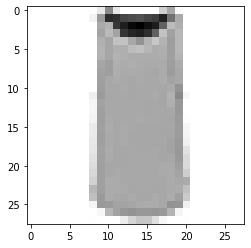

In [29]:
i=2
print(y_train_set[i])
plt.imshow(x_train_set[i],cmap='binary')
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_set, y_train_set, random_state=1)

In [31]:
tf.random.set_seed(1)
np.random.seed(1)

In [32]:
conv_encoder= keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='same',activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3,padding='same',activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3,padding='same',activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,kernel_size=3,strides=2,padding='valid',activation='selu',input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16,kernel_size=3,strides=2,padding='same',activation='selu'),
    keras.layers.Conv2DTranspose(1,kernel_size=3,strides=2,padding='same',activation='sigmoid'),
    keras.layers.Reshape([28,28])
])
conv_ae=keras.models.Sequential([conv_encoder, conv_decoder])

In [33]:
conv_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)         

In [34]:
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 32)         18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 16)       4624      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        145       
 ranspose)                                                       
                                                                 
 reshape_4 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
__________________________________________________

In [35]:
conv_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 3, 3, 64)          23296     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            23233     
                                                                 
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [36]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true),tf.round(y_pred))

In [37]:
conv_ae.compile(loss='binary_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate=1.0),
        metrics=[rounded_accuracy])

In [38]:
train = conv_ae.fit(x_train, x_train, epochs=20, validation_data=(x_valid, x_valid))

Epoch 1/20
1407/1407 [==============================] - 56s 40ms/step - loss: 0.3073 - rounded_accuracy: 0.9155 - val_loss: 0.2831 - val_rounded_accuracy: 0.9310
Epoch 2/20
1407/1407 [==============================] - 61s 43ms/step - loss: 0.2778 - rounded_accuracy: 0.9397 - val_loss: 0.2725 - val_rounded_accuracy: 0.9455
Epoch 3/20
1407/1407 [==============================] - 47s 33ms/step - loss: 0.2728 - rounded_accuracy: 0.9446 - val_loss: 0.2694 - val_rounded_accuracy: 0.9478
Epoch 4/20
1407/1407 [==============================] - 43s 31ms/step - loss: 0.2700 - rounded_accuracy: 0.9475 - val_loss: 0.2674 - val_rounded_accuracy: 0.9495
Epoch 5/20
1407/1407 [==============================] - 43s 31ms/step - loss: 0.2679 - rounded_accuracy: 0.9497 - val_loss: 0.2798 - val_rounded_accuracy: 0.9377
Epoch 6/20
1407/1407 [==============================] - 43s 31ms/step - loss: 0.2665 - rounded_accuracy: 0.9513 - val_loss: 0.2644 - val_rounded_accuracy: 0.9529
Epoch 7/20
1407/1407 [======

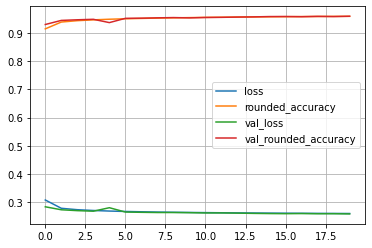

In [39]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

In [40]:
conv_ae.evaluate(x_test,x_test)

313/313 [==============================] - 3s 11ms/step - loss: 0.2610 - rounded_accuracy: 0.9592


[0.26096677780151367, 0.9591512084007263]

In [41]:
x_test_decoded = conv_ae.predict(x_test)

313/313 [==============================] - 3s 10ms/step


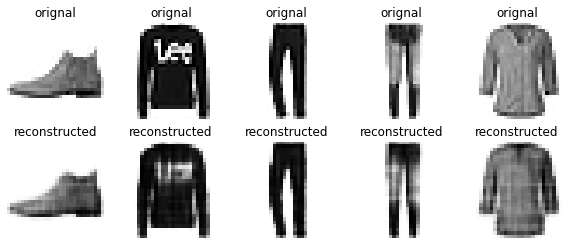

In [42]:
plt.figure(figsize=(10,4))
for i in range(5):
  plt.subplot(2,5,1+i)
  plt.imshow(x_test[i], cmap='binary')
  plt.title('orignal')
  plt.axis('off')

  plt.subplot(2,5,1+5+i)
  plt.imshow(x_test_decoded[i], cmap='binary')
  plt.title('reconstructed')
  plt.axis('off')
plt.show()

In [45]:
x_test_codings = conv_encoder.predict(x_test)
x_test_codings.shape

313/313 [==============================] - 3s 9ms/step


(10000, 3, 3, 64)

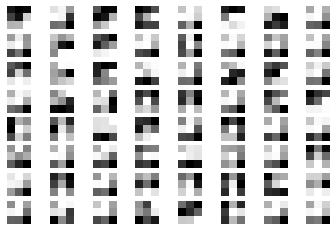

In [46]:
i = 0
for j in range(64):
  plt.subplot(8,8, 1+j)
  plt.imshow(x_test_codings[i,:,:,j], cmap='binary')
  plt.axis('off')

**Application: Unspervised Pretraining**

In [47]:
x_train_lab = x_train[:500]
y_train_lab = y_train[:500]

In [48]:
tf.random.set_seed(1)
np.random.seed(1)

In [49]:
clf = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16,kernel_size=3,padding='same',activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3,padding='same',activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3,padding='same',activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20,activation='selu'),
    keras.layers.Dense(10,activation='softmax')
])

In [50]:
clf.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 64)         

In [53]:
clf.compile(loss='sparse_categorical_crossentropy',
      optimizer=keras.optimizers.SGD(learning_rate=0.02),
      metrics=['accuracy'])

In [54]:
train = clf.fit(x_train_lab, y_train_lab, epochs=30,
         validation_data=(x_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 5s 288ms/step - loss: 2.1475 - accuracy: 0.2440 - val_loss: 1.9679 - val_accuracy: 0.4244
Epoch 2/30
16/16 [==============================] - 4s 251ms/step - loss: 1.7034 - accuracy: 0.5020 - val_loss: 1.4861 - val_accuracy: 0.5595
Epoch 3/30
16/16 [==============================] - 4s 248ms/step - loss: 1.3343 - accuracy: 0.5880 - val_loss: 1.2117 - val_accuracy: 0.5776
Epoch 4/30
16/16 [==============================] - 4s 252ms/step - loss: 1.0943 - accuracy: 0.6260 - val_loss: 1.0182 - val_accuracy: 0.6650
Epoch 5/30
16/16 [==============================] - 4s 260ms/step - loss: 0.9377 - accuracy: 0.6720 - val_loss: 0.9356 - val_accuracy: 0.6693
Epoch 6/30
16/16 [==============================] - 4s 249ms/step - loss: 0.8638 - accuracy: 0.6940 - val_loss: 1.0126 - val_accuracy: 0.6662
Epoch 7/30
16/16 [==============================] - 4s 278ms/step - loss: 0.8267 - accuracy: 0.7160 - val_loss: 0.8756 - val_accuracy: 0.6857
Epoch 

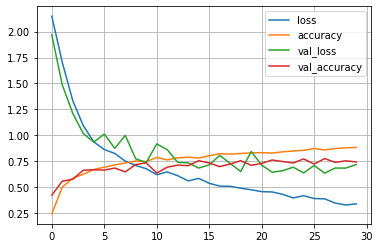

In [55]:
pd.DataFrame(train.history).plot()
plt.grid(True)
plt.show()

In [56]:
clf.evaluate(x_test,y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.7317 - accuracy: 0.7397


[0.7316502332687378, 0.7397000193595886]

In [57]:
y_proba = clf.predict(x_test,)
y_proba[:3].round(2)

313/313 [==============================] - 3s 8ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.58, 0.  , 0.34],
       [0.  , 0.  , 0.13, 0.  , 0.8 , 0.  , 0.06, 0.  , 0.01, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [58]:
y_pred = np.argmax(y_proba,axis=1)
y_pred[:3],y_test[:3]

(array([7, 4, 1]), array([9, 2, 1], dtype=uint8))

Model2:
Classifier with Unsupervised Pretraining

In [59]:
tf.random.set_seed(1)
np.random.seed(1)

In [61]:
conv_encoder_clone = keras.models.clone_model(conv_encoder)
conv_encoder_clone.set_weights(conv_encoder.get_weights())

In [62]:
pre_clf = keras.models.Sequential([
  conv_encoder_clone,
  keras.layers.Flatten(),
  keras.layers.Dense(20, activation='selu'),
  keras.layers.Dense(10, activation='softmax')
])

In [63]:
pre_clf.summary(show_trainable=True)
#Transfer learning初步的"Trainable"應該要被鎖定，也就是下表的第一個sequential

Model: "sequential_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_3 (Sequential)   (None, 3, 3, 64)          23296     Y          
                                                                            
 flatten_1 (Flatten)         (None, 576)               0         Y          
                                                                            
 dense_2 (Dense)             (None, 20)                11540     Y          
                                                                            
 dense_3 (Dense)             (None, 10)                210       Y          
                                                                            
Total params: 35,046
Trainable params: 35,046
Non-trainable params: 0
____________________________________________________________________________


In [64]:
pre_clf.compile(loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.SGD(learning_rate=0.02),
        metrics=['accuracy'])

In [65]:
#進行將第一個sequential的Trainable鎖定
conv_encoder_clone.trainable=False

In [66]:
pre_clf.summary(show_trainable=True)

Model: "sequential_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_3 (Sequential)   (None, 3, 3, 64)          23296     N          
                                                                            
 flatten_1 (Flatten)         (None, 576)               0         Y          
                                                                            
 dense_2 (Dense)             (None, 20)                11540     Y          
                                                                            
 dense_3 (Dense)             (None, 10)                210       Y          
                                                                            
Total params: 35,046
Trainable params: 11,750
Non-trainable params: 23,296
____________________________________________________________________________


In [68]:
train1 = pre_clf.fit(x_train_lab, y_train_lab, epochs=15,
            validation_data=(x_valid, y_valid))

Epoch 1/15
16/16 [==============================] - 4s 250ms/step - loss: 2.3397 - accuracy: 0.3580 - val_loss: 1.3867 - val_accuracy: 0.5327
Epoch 2/15
16/16 [==============================] - 4s 234ms/step - loss: 0.9554 - accuracy: 0.6720 - val_loss: 0.9287 - val_accuracy: 0.6567
Epoch 3/15
16/16 [==============================] - 3s 226ms/step - loss: 0.8144 - accuracy: 0.6740 - val_loss: 0.7848 - val_accuracy: 0.7271
Epoch 4/15
16/16 [==============================] - 4s 246ms/step - loss: 0.6669 - accuracy: 0.7480 - val_loss: 0.7566 - val_accuracy: 0.7184
Epoch 5/15
16/16 [==============================] - 5s 325ms/step - loss: 0.5927 - accuracy: 0.7740 - val_loss: 0.7522 - val_accuracy: 0.7261
Epoch 6/15
16/16 [==============================] - 4s 284ms/step - loss: 0.5208 - accuracy: 0.7980 - val_loss: 0.8528 - val_accuracy: 0.6969
Epoch 7/15
16/16 [==============================] - 4s 241ms/step - loss: 0.5087 - accuracy: 0.8240 - val_loss: 0.6610 - val_accuracy: 0.7563
Epoch 

In [69]:
conv_encoder_clone.trainable=True

In [70]:
pre_clf.summary(show_trainable=True)

Model: "sequential_7"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_3 (Sequential)   (None, 3, 3, 64)          23296     Y          
                                                                            
 flatten_1 (Flatten)         (None, 576)               0         Y          
                                                                            
 dense_2 (Dense)             (None, 20)                11540     Y          
                                                                            
 dense_3 (Dense)             (None, 10)                210       Y          
                                                                            
Total params: 35,046
Trainable params: 35,046
Non-trainable params: 0
____________________________________________________________________________


In [71]:
train2 = pre_clf.fit(x_train_lab, y_train_lab, epochs=15,
            validation_data=(x_valid, y_valid))

Epoch 1/15
16/16 [==============================] - 4s 264ms/step - loss: 0.2773 - accuracy: 0.9020 - val_loss: 0.6916 - val_accuracy: 0.7639
Epoch 2/15
16/16 [==============================] - 4s 234ms/step - loss: 0.2182 - accuracy: 0.9400 - val_loss: 0.6052 - val_accuracy: 0.7923
Epoch 3/15
16/16 [==============================] - 4s 240ms/step - loss: 0.2292 - accuracy: 0.9240 - val_loss: 0.6444 - val_accuracy: 0.7751
Epoch 4/15
16/16 [==============================] - 4s 235ms/step - loss: 0.2110 - accuracy: 0.9260 - val_loss: 0.6305 - val_accuracy: 0.7858
Epoch 5/15
16/16 [==============================] - 4s 236ms/step - loss: 0.2044 - accuracy: 0.9380 - val_loss: 0.6470 - val_accuracy: 0.7875
Epoch 6/15
16/16 [==============================] - 4s 261ms/step - loss: 0.1953 - accuracy: 0.9220 - val_loss: 0.8195 - val_accuracy: 0.7393
Epoch 7/15
16/16 [==============================] - 5s 339ms/step - loss: 0.1842 - accuracy: 0.9500 - val_loss: 0.6028 - val_accuracy: 0.7964
Epoch 

In [72]:
pre_clf.evaluate(x_test,y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.6675 - accuracy: 0.7951


[0.6674820184707642, 0.7950999736785889]

In [73]:
y_proba = pre_clf.predict(x_test)
y_proba[:3].round(2)

313/313 [==============================] - 4s 12ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.02, 0.25, 0.  , 0.3 , 0.  , 0.43],
       [0.  , 0.  , 0.94, 0.  , 0.01, 0.  , 0.05, 0.  , 0.01, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [74]:
y_pred = np.argmax(y_proba, axis=1)
y_pred[:3], y_test[:3]

(array([9, 2, 1]), array([9, 2, 1], dtype=uint8))